In [96]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import glob as glob
from sklearn import manifold

import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.manifold import MDS
from scipy.stats import norm, chi2

np.random.seed(0)

### 1 Prepare functions and data for plotting

In [5]:
def cov_ellipse(nmds_coords, q=None, nsig=None, **kwargs):
    
    """
    Solution from Syrtis Mayor: https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
    
    Parameters
    ----------
    cov : (2, 2) array
        Covariance matrix.
    q : float, optional
        Confidence level, should be in (0, 1)
    nsig : int, optional
        Confidence level in unit of standard deviations. 
        E.g. 1 stands for 68.3% and 2 stands for 95.4%.

    Returns
    -------
    width, height, rotation :
         The lengths of two axises and the rotation angle in degree
    for the ellipse.
    """

    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('One of `q` and `nsig` should be specified.')
    r2 = chi2.ppf(q, 2)
    
    # Calculate the covariance matrix
    cov = np.cov(nmds_coords.T)  # Transpose to get shape (n_dimensions, n_samples)

    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return(width, height, rotation)
    # Width and height are "full" widths, not radius


# Function to check if points are inside the ellipse
def is_inside_ellipse(x, y, a, b, angle, center_x, center_y):
    # Translate points to ellipse centered at origin
    x_translated = x - center_x
    y_translated = y - center_y
    
    # Rotate points
    cos_angle = np.cos(np.radians(angle))
    sin_angle = np.sin(np.radians(angle))
    x_rotated = x_translated * cos_angle + y_translated * sin_angle
    y_rotated = -x_translated * sin_angle + y_translated * cos_angle
    
    # Check if inside ellipse
    return (x_rotated**2 / a**2) + (y_rotated**2 / b**2) <= 1

In [6]:
# 1. Read
veg = gpd.read_file("data/VegType.gpkg")
veg['landcover_highest'] = veg['landcover_highest'].replace(to_replace={'Tall forbs':'Tall-growing forbs', 'Low forbs':'Low-growing forbs', 'Trees':'Conifer seedlings'})
veg['site_2'] = veg.loc[:,'site']
veg['site'] = veg['site'].replace({'Wildfire Chinchaga A':'Wildfires Chinchaga', 'Wildfire Chinchaga B':'Wildfires Chinchaga'})
veg['dataset_cluster_alpha'] = veg['dataset_cluster_alpha'].replace({'Wildfire Chinchaga A':'A Wildfires Chinchaga', 'Wildfire Chinchaga B':'B Wildfires Chinchaga'}, regex=True)

In [70]:
### 2. Create relative abundance matrices - CLUSTERED REFERENCES
rel_abundance = veg.loc[veg['site'].isin(['Wildfires Chinchaga'])].groupby(['site', 'dataset_cluster_alpha', 'landcover_highest'], as_index=False)['ID'].count().merge(veg.groupby(['dataset_cluster_alpha'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='dataset_cluster_alpha')
rel_abundance['Cover'] = rel_abundance['ID'] / rel_abundance['Total_cover'] * 100
rel_abundance = rel_abundance.pivot(index=['dataset_cluster_alpha'], columns='landcover_highest', values='Cover').fillna(0)
### same - RECLAMATION SITES
rel_abundance_ROW = veg.loc[veg['site'].isin(['ROW Chinchaga A', 'ROW Chinchaga B'])].groupby(['site', 'landcover_highest'], as_index=False)['ID'].count().merge(veg.groupby(['site'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='site')
rel_abundance_ROW['Cover'] = rel_abundance_ROW['ID'] / rel_abundance_ROW['Total_cover'] * 100
rel_abundance_ROW = rel_abundance_ROW.pivot(index=['site'], columns='landcover_highest', values='Cover').fillna(0)

rel_abundance = pd.concat([rel_abundance_ROW,rel_abundance])

### 3. Bray-Curtis and 2D NMDS
matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(rel_abundance, 'braycurtis'))

### 4. 2D NMDS
nmds_coords = manifold.MDS(n_components=2, metric=True, max_iter=100000, dissimilarity="precomputed",
                    random_state=0, n_jobs=-1, normalized_stress='auto').fit_transform(matrix)
nmds_coords = pd.DataFrame(nmds_coords).rename(columns={0:'NMDS1',1:'NMDS2'})
nmds_coords['Clusters'] = rel_abundance.index
nmds_coords['Site'] = nmds_coords['Clusters'].str.split('_', expand=True)[0].replace({'A ':'', 'B ':''}, regex=True)

# Check NMDS output
nmds_coords.head()

,NMDS1,NMDS2,Clusters,Site
0,-0.225390,0.123342,ROW Chinchaga A,ROW Chinchaga A
1,-0.394136,0.274641,ROW Chinchaga B,ROW Chinchaga B
2,0.281296,0.335995,A Wildfires Chinchaga_chunk1_0,Wildfires Chinchaga
3,0.236458,0.187948,A Wildfires Chinchaga_chunk1_1,Wildfires Chinchaga
4,0.228444,0.239683,A Wildfires Chinchaga_chunk1_2,Wildfires Chinchaga


### 2. Create plot

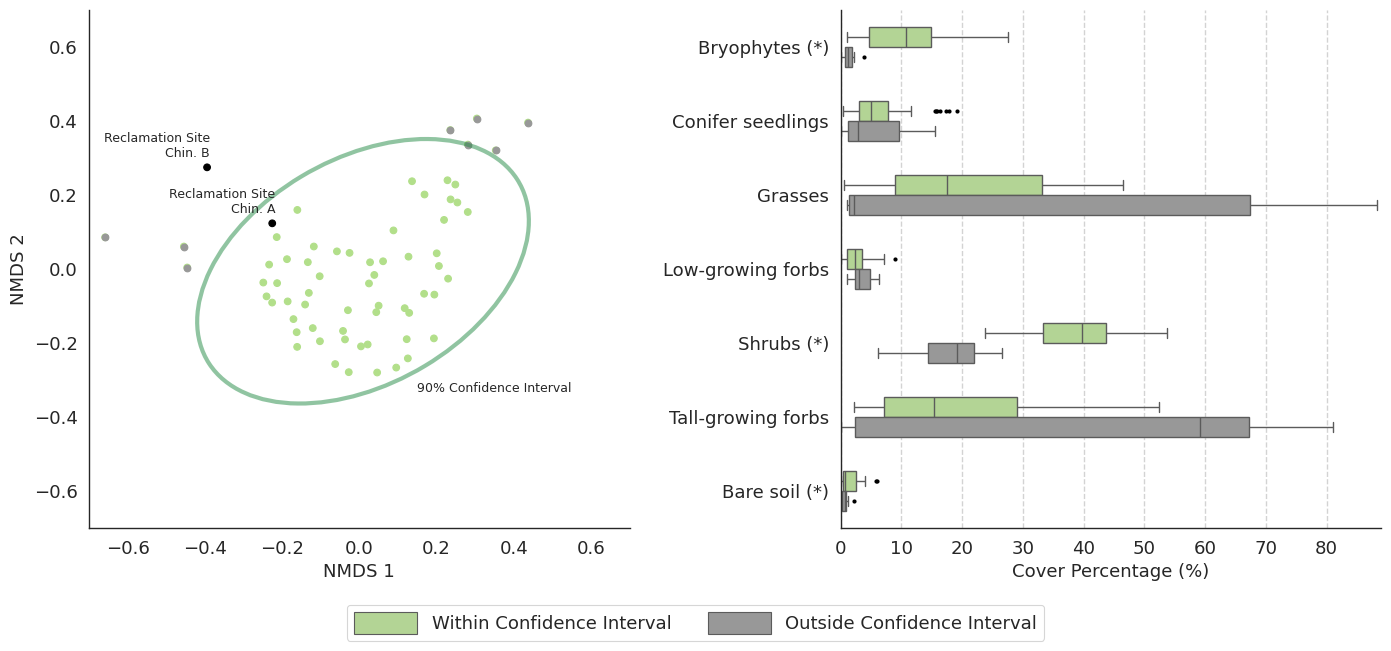

In [91]:
font_size = 13
bar_width = 0.55
conf_interval = 0.88

nmds_coords_select_1 = nmds_coords.loc[nmds_coords['Clusters'].str.contains('Wildfires Chinchaga'), ]
nmds_coords_select_2 = nmds_coords.loc[nmds_coords['Clusters'].str.contains('ROW Chinchaga'), ]


### 1. Setup plot
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
fig, axs = plt.subplots(1,2, figsize=(14,6), sharex=False, sharey=False)

### 2. Map categories to colors
color_map = {'Wildfires Chinchaga':'#b2df8a', 
             'ROW Chinchaga A':'#000000', 'ROW Chinchaga B':'#000000'}
colors = nmds_coords['Site'].map(color_map)

### 3. Plot NMDS points
axs[0].scatter(nmds_coords.loc[:, 'NMDS1'], nmds_coords.loc[:, 'NMDS2'], color=colors)

### 4. Plot Confidence elipse
width, height, rotation = cov_ellipse(nmds_coords_select_1.loc[:,['NMDS1','NMDS2']].to_numpy(), q=conf_interval) # Create
pos = np.mean(nmds_coords_select_1.loc[:,['NMDS1','NMDS2']].to_numpy(), axis=0) # Calculate the position (mean of NMDS coordinates)
ellip = Ellipse(xy=pos, width=width, height=height, angle=rotation, edgecolor='#238b45', facecolor='none', alpha=0.5, linewidth=3) # Plot

### 5. Find points outsite elipsoid
inside_mask = is_inside_ellipse(nmds_coords_select_1['NMDS1'], nmds_coords_select_1['NMDS2'], 
                                width/2, height/2, rotation, pos[0], pos[1])
outside_points = nmds_coords_select_1[~inside_mask] # Points outside the ellipse

### 6. Plot crosses for points outside elipsoid
axs[0].scatter(outside_points['NMDS1'], outside_points['NMDS2'], color='#989898')  # s is the size of the marker

### 7. Add labels to the shown reclamation sites 
for idx, row in nmds_coords_select_2.iterrows():
    text = row['Site'].replace("ROW ","Reclamation Site\n").replace("Chinchaga","Chin.")
    axs[0].text(row['NMDS1']+0.0075, row['NMDS2']+0.02, text, fontsize=9, ha='right', va='bottom')

text = "90% Confidence Interval"
axs[0].text(0.15, -0.34, text, fontsize=9, ha='left', va='bottom')

### 8. Further customization of plot
axs[0].add_artist(ellip)
axs[0].set_xlim([-0.7, 0.7])
axs[0].set_ylim([-0.7, 0.7])
axs[0].set_xlabel('NMDS 1', fontsize=font_size)
axs[0].set_ylabel('NMDS 2', fontsize=font_size)

# 9. Start with second plot:
# Boxplots/Barplots with confidence intervals. They are showing for each plant functional type the relative cover for the following groups:
# * within conf. elipse
# * outside conf. elipse
rel_abundance_2 = veg.loc[veg['site'].isin(['Wildfires Chinchaga'])].groupby(['site', 'dataset_cluster_alpha', 'landcover_highest'], as_index=False)['ID'].count().merge(veg.groupby(['dataset_cluster_alpha'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='dataset_cluster_alpha')
rel_abundance_2['Cover'] = rel_abundance_2['ID'] / rel_abundance_2['Total_cover'] * 100
rel_abundance_2['within_conf'] = np.where(rel_abundance_2['dataset_cluster_alpha'].isin(nmds_coords_select_1[~inside_mask]['Clusters']), "Outside Confidence Interval", "Within Confidence Interval")

rel_abundance_2["landcover_highest"] = rel_abundance_2["landcover_highest"].replace({'Bryophytes':'Bryophytes (*)', 'Shrubs':'Shrubs (*)', 'Bare soil':'Bare soil (*)'})
rel_abundance_2["landcover_highest"] = pd.Categorical(rel_abundance_2["landcover_highest"], categories=['Bryophytes (*)', 'Conifer seedlings', 'Grasses',
                                                                                                            'Low-growing forbs', 'Shrubs (*)', 'Tall-growing forbs',
                                                                                                            'Bare soil (*)'], ordered=True)
rel_abundance_2 = rel_abundance_2.sort_values(by=["landcover_highest"])

cmap = {'Within Confidence Interval':'#b2df8a', "Outside Confidence Interval":"#989898"}

sns.boxplot(data=rel_abundance_2, y='landcover_highest', x='Cover', 
            flierprops={"marker":"o", "markerfacecolor":"black", "markersize":3, "linestyle":"none", "markeredgecolor":"none"},
            hue='within_conf',  ax=axs[1], palette=cmap, width=bar_width)

# 10. More customizations... 
axs[1].set_xlabel("Cover Percentage (%)", fontsize=font_size)
axs[1].set_ylabel("")
# Add vertical lines
axs[1].xaxis.grid(color='lightgray', linestyle='--', linewidth=1)
axs[1].legend().remove() # Remove legend
axs[1].set_xlim([0,89])

for ax in axs:
    # Set the fontsize for x-tick labels directly 
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

# Add a common legend outside the subplots
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2, handlelength=3.5, handleheight=1.5, prop={'size':font_size})

# 11. Show plot
sns.despine()
plt.tight_layout(h_pad = 2.5, w_pad=2.5)
#plt.savefig('figures/Selection_with_90conf.jpg',dpi=1200,bbox_inches='tight')

### Check some stats

In [88]:
conf_std_1 = rel_abundance_2.groupby(['within_conf', 'landcover_highest'], as_index=False)['Cover'].quantile(0.25).sort_values('landcover_highest').rename(columns={'Cover':'p25'})
conf_std_2 = rel_abundance_2.groupby(['within_conf', 'landcover_highest'], as_index=False)['Cover'].quantile(0.75).sort_values('landcover_highest').rename(columns={'Cover':'p75'})



conf_std = pd.merge(conf_std_1, conf_std_2)
conf_std['IQR'] = conf_std['p75'] - conf_std['p25']
conf_std = conf_std.pivot(index='landcover_highest', columns='within_conf', values='IQR').reset_index().rename(columns={'Outside Confidence Interval':'IQR Outside Conf Int',
                                                                                                                          'Within Confidence Interval':'IQR Within Conf Int'})
conf_std.loc[:, ['IQR Outside Conf Int', 'IQR Within Conf Int']] = conf_std.loc[:, ['IQR Outside Conf Int', 'IQR Within Conf Int']].round(decimals=2)
conf_std

within_conf,landcover_highest,IQR Outside Conf Int,IQR Within Conf Int
0,Bryophytes (*),1.16,10.21
1,Conifer seedlings,8.52,4.87
2,Grasses,66.04,24.22
3,Low-growing forbs,2.47,2.47
4,Shrubs (*),7.48,10.25
5,Tall-growing forbs,64.91,21.88
6,Bare soil (*),0.66,2.10


In [95]:
from scipy.stats import ttest_ind, levene, bartlett

keys = []
barlett_results = []
levene_results = []
ttest_results = []
conclusions = []
p_symbols = []
for i in rel_abundance_2['landcover_highest'].unique():
    data = rel_abundance_2.loc[rel_abundance_2['landcover_highest']==i]
    # This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. 
    # This test assumes that the populations have identical variances by default.
    # However, when equal_var=False, Welch’s t-test is performed, which does not assume equal population variance.
    # If the p-value is smaller than our threshold (e.g. 0.05), then we have evidence against the null hypothesis of equal population means, so we reject the hypothesis.
    barletttest = bartlett(data.loc[data['within_conf'] == 'Within Confidence Interval', 'Cover'], data.loc[data['within_conf'] == 'Outside Confidence Interval', 'Cover'])
    levenetest = levene(data.loc[data['within_conf'] == 'Within Confidence Interval', 'Cover'], data.loc[data['within_conf'] == 'Outside Confidence Interval', 'Cover'])
    ttest = ttest_ind(data.loc[data['within_conf'] == 'Within Confidence Interval', 'Cover'], data.loc[data['within_conf'] == 'Outside Confidence Interval', 'Cover'], equal_var=False)
    keys.append(i)
    levene_results.append({'statistic':round(levenetest.statistic, 2), 'pvalue':round(levenetest.pvalue, 4)})
    barlett_results.append({'statistic':round(barletttest.statistic, 2), 'pvalue':round(barletttest.pvalue, 4)})
    ttest_results.append({'statistic':round(ttest.statistic, 2), 'pvalue':round(ttest.pvalue, 4)})
    
    if ttest.pvalue < 0.05:
        conclusions.append(f'Difference in the mean composition of {i}')
    else:
        conclusions.append(f'No difference in the mean composition of {i}')
        
    if ttest.pvalue > 0.05:
        p_symbols.append('None')
    elif (ttest.pvalue <= 0.001) & (ttest.pvalue > 0.0001):
        p_symbols.append('***')
    elif (ttest.pvalue <= 0.01) & (ttest.pvalue > 0.001):
        p_symbols.append('**')
    elif (ttest.pvalue <= 0.05) & (ttest.pvalue > 0.01):
        p_symbols.append('*')
    if ttest.pvalue <= 0.0001:
        p_symbols.append('****')

ttest_results = pd.DataFrame({'tests':keys,
                 'barlett_results':barlett_results,
                 'levene_results':levene_results,
                 'ttest_results':ttest_results,
                 'conclusion':conclusions,
                 'p_symbols':p_symbols})
# Check
ttest_results = pd.merge(ttest_results, conf_std, left_on='tests', right_on='landcover_highest')
ttest_results['IQR_%diff'] = (((ttest_results['IQR Outside Conf Int']-ttest_results['IQR Within Conf Int'])/((ttest_results['IQR Outside Conf Int']+ttest_results['IQR Within Conf Int'])/2))*100).abs()
ttest_results

,tests,barlett_results,levene_results,ttest_results,conclusion,p_symbols,landcover_highest,IQR Outside Conf Int,IQR Within Conf Int,IQR_%diff
0,Bryophytes (*),"{'statistic': 17.49, 'pvalue': 0.0}","{'statistic': 12.16, 'pvalue': 0.0009}","{'statistic': 9.12, 'pvalue': 0.0}",Difference in the mean composition of Bryophyt...,****,Bryophytes (*),1.16,10.21,159.190853
1,Conifer seedlings,"{'statistic': 0.48, 'pvalue': 0.4874}","{'statistic': 0.34, 'pvalue': 0.5606}","{'statistic': 0.49, 'pvalue': 0.6364}",No difference in the mean composition of Conif...,None,Conifer seedlings,8.52,4.87,54.518297
2,Grasses,"{'statistic': 19.38, 'pvalue': 0.0}","{'statistic': 11.94, 'pvalue': 0.001}","{'statistic': -0.8, 'pvalue': 0.4536}",No difference in the mean composition of Grasses,None,Grasses,66.04,24.22,92.665633
3,Low-growing forbs,"{'statistic': 0.0, 'pvalue': 0.9697}","{'statistic': 0.04, 'pvalue': 0.8457}","{'statistic': -1.42, 'pvalue': 0.1887}",No difference in the mean composition of Low-g...,None,Low-growing forbs,2.47,2.47,0.000000
4,Shrubs (*),"{'statistic': 0.21, 'pvalue': 0.6438}","{'statistic': 1.22, 'pvalue': 0.2731}","{'statistic': 8.6, 'pvalue': 0.0}",Difference in the mean composition of Shrubs (*),****,Shrubs (*),7.48,10.25,31.246475
5,Tall-growing forbs,"{'statistic': 13.77, 'pvalue': 0.0002}","{'statistic': 11.6, 'pvalue': 0.0012}","{'statistic': -1.88, 'pvalue': 0.0996}",No difference in the mean composition of Tall-...,None,Tall-growing forbs,64.91,21.88,99.158889
6,Bare soil (*),"{'statistic': 5.2, 'pvalue': 0.0226}","{'statistic': 1.68, 'pvalue': 0.2006}","{'statistic': 2.24, 'pvalue': 0.0349}",Difference in the mean composition of Bare soi...,*,Bare soil (*),0.66,2.10,104.347826
